# <font color='blue'>Lab 09 - One Eye, blue eye? Two eyes, gray eyes?</font>

### Earth 468: Data analysis, Inference, and Estimation

#### Lab developed by E.A. Hetland 

**Objective:** Explore hierarchical cluster analysis, namely how selection of the number of clusters and the color space chosen affect the outcome. 

**Python Objective:** Learn how to read in an image as data; learn how to modify a cluster analysis tool from the Sci-Kit Learn library

**Data:** An image file *ImageBlueEyes-lab.png* in which the left eye may appear blue in relation to the hair bead.

<img src="ImageBlueEyes-lab.png">

## <font color='orange'>Exercise 40 points</font>

Colors can be represented in a number of spaces, including a color wheel, a color cube, the so-called L*a*b* space, or 2D planes representing colors as seen in various forms of colorblindness. All of these spaces are related to each other through coordinate transformations and maps.

<img src="colorwheel_example.png">

In this lab, we will focus on the space of colors represented by a unit cube in a 3D Cartesian space with coordinates red (R), green (G), and blue (B), as well as a representation of a 2D plane of all the RGB colors converted to their equivalents under deuteranope colorblindness. As the coordinates of the color cube are R, G, and B, I will refer to this space as the RGB space.

We will use an RGB to deuteranope vision (characterized by lack of the green retinal photoreceptors) transformation from Viénot et al. (1999: “Digital Video Colourmaps for Checking the Legibility of Displays by Dichromats”, Color Research and Application). The deuteran transformation results in a deuteranope space with coordinates with unbalanced ranges, which for simplicity I uniformly rescale to a unit square. The below plots show colors in the hue-saturation-value (HSV) spectrum in deuteranope space, coloring the circles by their original color (right) and deuteranope equivalent (left):

<img src="deuteranope_vision.png">

Quantifying how close, or similar, two colors are is achieved by measuring the distance between those colors. The measurement of distance between colors is a seemingly a simple problem, but as everyone perceives color differently, a single robust distance measure for colors poses a challenge. The simplest distance measure is to just use the Euclidean distance (i.e., L2 distance) in RGB space.

For this lab, you will need to use the functions that are provided below in this notebook handout to convert between different color spaces.

Run the following cell to import the required libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  

from PIL import Image

from sklearn.cluster import AgglomerativeClustering

Run the following cell for use of the color space conversion functions:

In [2]:
#Convert from RGB to LAB colorspace:
def RGB2LAButil(t):
    a = np.zeros(t.shape)
     
    pos = np.where(t > (6/29)**3)[0];
    a[pos] = t[pos]**(1/3)
    
    pos = np.where(t <= (6/29)**3)[0];
    a[pos] = t[pos]*(1/3)*( (29/6)**2) + 4/29
    
    return np.reshape(a,(a.size,1))

def RGB2LAB(rchannel,gchannel,bchannel):
    rgb2xyz = np.array([[40.9568,35.5041,17.9167],[21.3389,70.6743,7.98680],[1.86297,11.4620,91.2367]])
    nfact = np.matmul(rgb2xyz,np.array([1,1,1]))

    rgb = np.concatenate((rchannel/255.,gchannel/255.,bchannel/255.),axis=1)

    NEWrgb = rgb**2.2
    xyz = np.zeros(rgb.shape)
    for k in range(0,rgb.shape[0]):
        xyz[k] = np.matmul(rgb2xyz,NEWrgb[k])/nfact
    
    Lchannel = 116.0 * RGB2LAButil(xyz[:,1]) - 16.0
    Achannel = 500.0 * ( RGB2LAButil(xyz[:,0]) - RGB2LAButil(xyz[:,1]) )
    Bchannel = 200.0 * ( RGB2LAButil(xyz[:,1]) - RGB2LAButil(xyz[:,2]) )

    return np.concatenate((Lchannel,Achannel,Bchannel),axis=1)



#Convert from RGB colorspace to deuteranope equivalent:
def RGB2ColorBlind(rchannel,gchannel,bchannel,typeflag):
    """
    CBcol, CBxy, CBxyz = RGB2ColorBlind(rchannel,gchannel,bchannel,type)
    
    computes the locations of the rgb colors in a 2D color blind
    space, using the relations given by
    http://vision.psychol.cam.ac.uk/jdmollon/papers/colourmaps.pdf
    
    Note: the 2D dichromatic color space is rescaled to be on order
    of a unit square
    
    typeflag = 1 for protanope and 2 for deuteranope color blindness
    
    OUTPUT: 
    col = [r g b] equivalents of the color under the given colorblind
            transformation
    xy = [x y] positions of the color in the 2D colorblind plane
    xyz = [z y z] positions of the color in the 2D colorblind plane
           expressed in the RGB color space
    
    E. Hetland, ehetland@umich.edu
    EARTH 468, F14, Univ. Michigan
    """
    
    rgb2lms = np.array([[17.8824,43.5161,4.11935],[3.45565,27.1554,3.86714],[0.0299566,0.184309,1.46709]])
    xyz2col = np.array([[0.080944,-0.130504,0.116721],[-0.0102485,0.0540194,-0.113615],[-0.000365294,-0.00412163,0.693513]])
    
    rgb = np.concatenate((rchannel/255.,gchannel/255.,bchannel/255.),axis=1)
    
    NEWrgb = rgb**2.2

    if typeflag==1:
        # for protanopia
        rgbslope = 0.992052
        rgbinter = 0.003974
        lms2col = np.array([[0.0,2.02344,-2.52581],[0.0,1.0,0.0],[0.0,0.0,1.0]])
        xytran = np.array([[0.2942,0.0067],[73.7417,1.6747]])
        scalex = 1.0

    if typeflag==2:
        # deuteranopia
        rgbslope = 0.957237
        rgbinter = 0.0213814
        lms2col = np.array([[1.0,0.0,0.0],[0.494207,0.0,1.24827],[0.0,0.0,1.0]])
        xytran = np.array([[1.5830,0.0359],[72.4530,1.6454]])
        scalex = 1;

    NEWrgb[:,0] = rgbslope*NEWrgb[:,0] + rgbinter;
    NEWrgb[:,1] = rgbslope*NEWrgb[:,1] + rgbinter;
    NEWrgb[:,2] = rgbslope*NEWrgb[:,2] + rgbinter;

    xyz = np.zeros(rgb.shape)
    col = np.zeros(rgb.shape)
    for k in range(0,rgb.shape[0]):
        lms = np.matmul(rgb2lms,NEWrgb[k])
        xyz[k] = np.matmul(lms2col,lms)
        col[k] = np.matmul(xyz2col,xyz[k])**(1.0/2.2)

    # hack to keep colors [0,1] and then map to [1,255] color range
    col = 254*np.clip(col,0.0,1.0)+1.0
    col = np.round(col).astype(np.uint8)
    
    xy = np.transpose(np.array([np.sqrt(xyz[:,0]**2 + xyz[:,1]**2),xyz[:,2]]))

    mtran = np.array([1.0/(xytran[1,0]-xytran[0,0]), 1.0/(xytran[1,1]-xytran[0,1])])
    xy[:,0] = xy[:,0]*mtran[0]
    xy[:,1] = xy[:,1]*mtran[1]*scalex
    
    return col, xy, xyz

## <font color='red'>(a)</font>
Images can be read into *Python* using <b>A=Image.open("filename.png")</b>. You can then plot the original image by calling <b>plt.imshow(A)</b>.

Read the image ImageBlueEyes-lab.png into *Python* and plot the image. Convert the image into a numpy array called *imarray* and calculate its dimensions. Save the shape of its first two dimensions for future use as *imdim*.

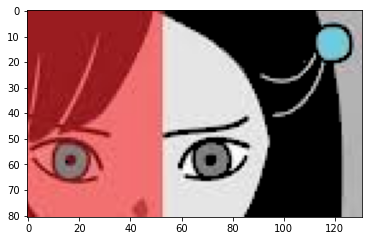

In [3]:
A = Image.open('ImageBlueEyes-lab.png')
plt.imshow(A)

In [4]:
imarray = np.array(A)
np.shape(imarray)
imdim = np.shape(imarray)[0:2]

## <font color='red'>(b)</font>
Let's reshape our image array to isolate the RGB channels as the columns of a new array. Plot the columns of this new array in a 3 dimensional plot to form a RGB color cube.

red


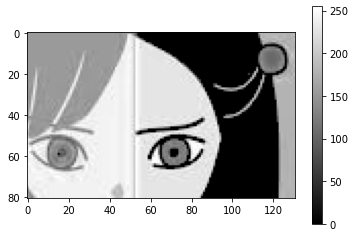

green


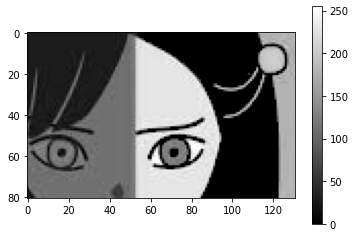

blue


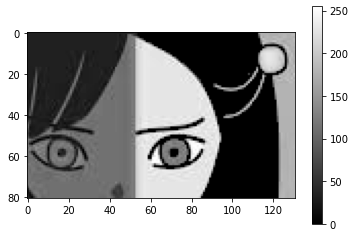

In [5]:
channel = ['red','green','blue']
for k in range(0,3):
    print(channel[k])
    fig = plt.figure()
    plt.imshow(imarray[:,:,k],cmap='gray')
    plt.colorbar()
    plt.show()

In [6]:
# For reshaping our image array:

newshape = (imarray[:,:,0].size,1)

rchannel = np.reshape(imarray[:,:,0],newshape)
gchannel = np.reshape(imarray[:,:,1],newshape)
bchannel = np.reshape(imarray[:,:,2],newshape)

rgb = np.concatenate((rchannel,gchannel,bchannel),axis=1)
print(rgb.shape) # Check that reshaping was effective

(10611, 3)


Text(0.5, 0.92, 'RGB Color Cube')

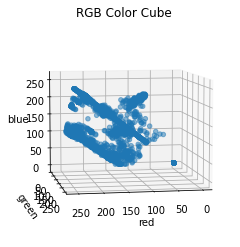

In [7]:
# 3-D plot of an RGB color cube:

# For rotating 3-D plots:
# %matplotlib notebook
# %matplotlib notebook
# Plot each column from our RGB array as an axis in our color cube
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.view_init(7,80)

ax.scatter(rgb[:,0],rgb[:,1],rgb[:,2],alpha=0.5)
ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')
ax.set_title('RGB Color Cube')


## <font color='red'>(c)</font>
Let's convert from RGB colorspace to the deuteranope equivalent using the function provided at the beginning of this lab. Use the following lines of code:

```Python
CBcol, CBxy, CBxyz = RGB2ColorBlind(rchannel,gchannel,bchannel,2)
CBarray = np.dstack((np.reshape(CBcol[:,0],imdim),np.reshape(CBcol[:,1],imdim),np.reshape(CBcol[:,2],imdim)))
```

In the deuteranope space, plot a 2 dimensional scatter plot for the two visible axes in this space as our equivalent to a colorcube.


In [8]:
CBcol, CBxy, CBxyz = RGB2ColorBlind(rchannel,gchannel,bchannel,2)
CBarray = np.dstack((np.reshape(CBcol[:,0],imdim),np.reshape(CBcol[:,1],imdim),np.reshape(CBcol[:,2],imdim)))

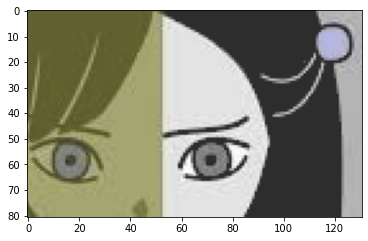

In [9]:
CBim = Image.fromarray(CBarray)
plt.imshow(CBim)

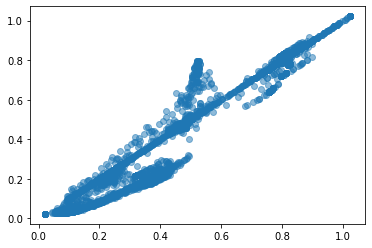

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(CBxy[:,0],CBxy[:,1],alpha = 0.5)
plt.show()

## <font color='red'>(d)</font>
Let's now perform a clustering analysis of our deuteranope colorspace using the *sklearn.cluster* function *AgglomerativeClustering*. As the name suggests, *AgglomerativeClustering* is a function that invokes an agglomerative algorithm. 

You have already imported the agglomerative function above by using:
```Python 
from sklearn.cluster import AgglomerativeClustering
```
We can call it with the command:
```Python 
AgglomerativeClustering(n_clusters=2, affinity='euclidean', connectivity=None, linkage='average')
```
We will explore a few of the included keyword arguments in this lab, namely, **n_clusters**. **n_clusters** is the preset number of clusters, **affinity** is the desired distance measure to be used, **connectivity** can establish some a priori structure from your data to be taken into consideration other that just the distance measure, and **linkage** is the desired type of linkage.

First, choose a number of clusters to represent the distinct features. Create a plot of the clustering in the deuteranope space shown in a RGB color cube that highlights these clusters.

Use the following lines of code for plotting your clusters, shown in a RGB color cube: 
```Python
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(7, -80)
for k in np.unique(label):
    ax.scatter(rgb[label == k, 0], rgb[label == k, 1], rgb[label == k, 2],
               color=plt.cm.jet(np.float(k) / np.max(label + 1)),
               s=20, edgecolor='k')
ax.set_title('clustering in __ space, shown in RGB cube')
plt.show()
```

In [11]:
NumClusters = 2
clusters = AgglomerativeClustering(n_clusters=2, affinity='euclidean', connectivity=None, linkage='average').fit(CBxy)


In [13]:
label = clusters.labels_
np.unique(label)

array([0, 1])

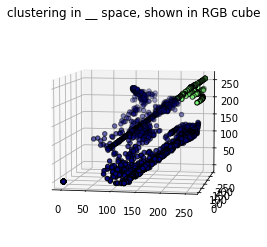

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(7, -80)
for k in np.unique(label):
    ax.scatter(rgb[label == k, 0], rgb[label == k, 1], rgb[label == k, 2],
               color=plt.cm.jet(float(k) / np.max(label + 1)),
               s=20, edgecolor='k')
ax.set_title('clustering in __ space, shown in RGB cube')
plt.show()

## <font color='red'>(e)</font>
To further explore your clustering, you may want to plot the pixels that have been separated into distinct clusters.
Try the following lines of code to plot the pixels that belong to a cluster as a white value:
```python
for k in np.unique(label):
    fig=plt.figure()
    a = np.zeros((imarray[:,:,0].size,1))
    a[label==k]=1
    b = np.reshape(a,imdim)
    plt.imshow(b,cmap='gray')
    plt.colorbar()
    plt.title('cluster %d' % k)
    plt.show()
```

Use the next lines of code to plot the pixels that belong to a cluster as its original RGB value:
```python
fig = plt.figure(figsize=[4,3*NumClusters])
axes = fig.subplots(NumClusters)
for k in np.unique(label):
    rgbTemp = np.concatenate((rchannel,gchannel,bchannel),axis=1);
    for j in np.setdiff1d(np.array([i for i in range(NumClusters)]),k):
        rgbTemp[label==j]=[255,255,255]   
    R = np.reshape(rgbTemp[:,0],imdim);
    G = np.reshape(rgbTemp[:,1],imdim);
    B = np.reshape(rgbTemp[:,2],imdim);
    imTemp = np.dstack((R,G,B))
    im=Image.fromarray(imTemp)
    axes[k].imshow(im)
    axes[k].set_title('cluster %d' % k)
    plt.imshow(im)
```

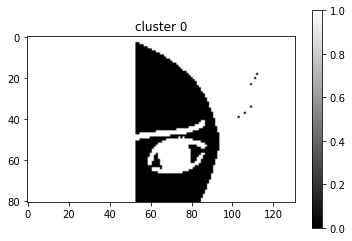

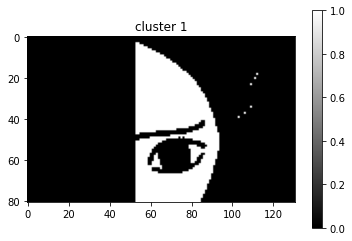

In [16]:
for k in np.unique(label):
    fig=plt.figure()
    a = np.zeros((imarray[:,:,0].size,1))
    a[label==k]=1
    b = np.reshape(a,imdim)
    plt.imshow(b,cmap='gray')
    plt.colorbar()
    plt.title('cluster %d' % k)
    plt.show()

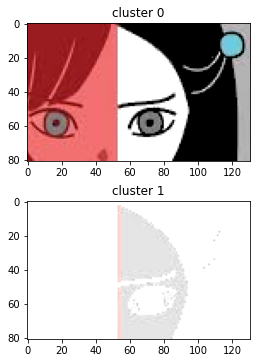

In [17]:
fig = plt.figure(figsize=[4,3*NumClusters])
axes = fig.subplots(NumClusters)
for k in np.unique(label):
    rgbTemp = np.concatenate((rchannel,gchannel,bchannel),axis=1);
    for j in np.setdiff1d(np.array([i for i in range(NumClusters)]),k):
        rgbTemp[label==j]=[255,255,255]   
    R = np.reshape(rgbTemp[:,0],imdim);
    G = np.reshape(rgbTemp[:,1],imdim);
    B = np.reshape(rgbTemp[:,2],imdim);
    imTemp = np.dstack((R,G,B))
    im=Image.fromarray(imTemp)
    axes[k].imshow(im)
    axes[k].set_title('cluster %d' % k)
    plt.imshow(im)

## <font color='red'>(f)</font>
Determine in your breakout room whether you will continue to explore the image in either RGB colorspace or LAB colorspace. If you choose RGB, repeat parts (d) and (e) using the array <b>rgb</b> that you created previously. If you choose LAB, repeat parts (d) and (e) after running the following code to convert RGB to LAB colors:
```python
lab = RGB2LAB(rchannel,gchannel,bchannel)
```
You will need to repeat the AgglomerativeClustering command, this time fitting either *lab* or *rgb*. 

Discuss how many clusters are required to differentiate the left iris so that you can determine its color. What happens when you allow for more clusters? And finally, what color *is* the left iris, after all? 


In [49]:
NumClusters = 4
clusters = AgglomerativeClustering(n_clusters=4, affinity='euclidean', connectivity=None, linkage='average').fit(rgb)
label = clusters.labels_

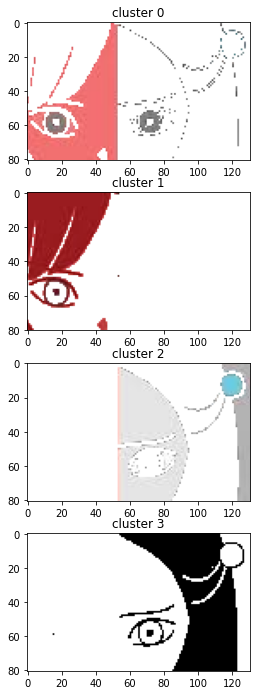

In [50]:
fig = plt.figure(figsize=[4,3*NumClusters])
axes = fig.subplots(NumClusters)
for k in np.unique(label):
    rgbTemp = np.concatenate((rchannel,gchannel,bchannel),axis=1);
    for j in np.setdiff1d(np.array([i for i in range(NumClusters)]),k):
        rgbTemp[label==j]=[255,255,255]   
    R = np.reshape(rgbTemp[:,0],imdim);
    G = np.reshape(rgbTemp[:,1],imdim);
    B = np.reshape(rgbTemp[:,2],imdim);
    imTemp = np.dstack((R,G,B))
    im=Image.fromarray(imTemp)
    axes[k].imshow(im)
    axes[k].set_title('cluster %d' % k)
    plt.imshow(im)

Four clusters are required to differentiate the left iris so that you can determine its color. When you allow for more clusters, the extra clusters are unnecessary and just shows a few colored dots. The left iris is gray, rather than the blue it initially appear as.

## <font color='red'>(g) 40 pts</font>

For full credit, upload a file to Canvas of your final plots representing the clusters for your chosen colorspace. There is no formal write-up required.